##  ECEN 524 -- Project 1, Part B -- Trajectory Alignment
### Peter (Yinghao) Chen and Nicholas Kenny

### Part 1 (Apply Dynamic Time Warping to Similar Trajectories)
Apply DTW by selecting the two demonstrated trajectories that are the more similar. Provide the DTW library you implemented, screenshots of your results, and an explanation of which demonstrated trajectories were selected and why.


#### What is Dynamic Time Warping (DTW)?
DTW is a technique for measuring similarity between two time sequences that may vary in speed or timing. Unlike simple distance measures like Euclidean distance, DTW can handle sequences of different lengths and accounts for shifts, stretches, and compressions in time. This makes it perfect for comparing robot trajectories that might execute the same basic motion at different speeds. This helps us with robot learning because we can demonstrate the required trajectory multiple times at varying speeds and still be able to train our models off of this data. DTW is useful in other disciplines for identifying patterns even when the underlying source changes, such as stock trading data.

The DTW distance provides a measure of similarity that:
- Is invariant to the speed of execution
- Considers the entire shape of the trajectory
- Handles trajectories of different lengths
- Takes into account all three spatial dimensions simultaneously

For our implementation, utilized the FastDTW Python Package - https://github.com/rmaestre/FastDTW .

In [2]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

def extract_ee_positions(df):
    """
    Extract end effector positions from dataframe into a numpy array
    """
    return np.column_stack((
        df['EE Position x'],
        df['EE Position y'],
        df['EE Position z']
    ))

def calculate_dtw_distance(traj1, traj2):
    """
    Calculate DTW distance between two trajectories
    Returns distance and warping path
    """
    distance, path = fastdtw(traj1, traj2, dist=euclidean)
    return distance, path

def find_most_similar_trajectories(trajectories):
    """
    Find the two most similar trajectories using DTW
    
    Parameters:
    trajectories: list of pandas DataFrames containing trajectory data
    
    Returns:
    tuple: (idx1, idx2, distance, warping_path)
    """
    n_trajectories = len(trajectories)
    min_distance = float('inf')
    most_similar = None
    
    # Extract positions for all trajectories
    position_sequences = [extract_ee_positions(df) for df in trajectories]
    
    # Compare all pairs
    for i, j in combinations(range(n_trajectories), 2):
        distance, path = calculate_dtw_distance(position_sequences[i], position_sequences[j])
        
        if distance < min_distance:
            min_distance = distance
            most_similar = (i, j, distance, path)
    
    return most_similar

def visualize_dtw_alignment(traj1, traj2, path, title="DTW Alignment of Trajectories"):
    """
    Visualize the DTW alignment between two trajectories
    """
    # Create 3D plot
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot both trajectories
    pos1 = extract_ee_positions(traj1)
    pos2 = extract_ee_positions(traj2)
    
    ax.plot(pos1[:, 0], pos1[:, 1], pos1[:, 2], 'b-', label='Trajectory 1', alpha=0.7)
    ax.plot(pos2[:, 0], pos2[:, 1], pos2[:, 2], 'r-', label='Trajectory 2', alpha=0.7)
    
    # Plot alignment lines for a subset of points to avoid cluttering
    path = np.array(path)
    step = max(len(path) // 20, 1)  # Show about 20 alignment lines
    for i, j in path[::step]:
        ax.plot([pos1[i, 0], pos2[j, 0]],
                [pos1[i, 1], pos2[j, 1]],
                [pos1[i, 2], pos2[j, 2]],
                'g-', alpha=0.3)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title(title)
    ax.legend()
    
    return fig

def analyze_trajectory_similarity(file_paths):
    """
    Analyze and visualize trajectory similarity using DTW
    """
    # Load trajectories
    trajectories = [pd.read_csv(path) for path in file_paths]
    
    # Find most similar pair
    idx1, idx2, distance, path = find_most_similar_trajectories(trajectories)
    
    print(f"\nDTW Analysis Results:")
    print("-" * 50)
    print(f"Most similar trajectories: {file_paths[idx1]} and {file_paths[idx2]}")
    print(f"DTW distance: {distance:.2f}")
    
    # Visualize the alignment
    fig = visualize_dtw_alignment(
        trajectories[idx1], 
        trajectories[idx2], 
        path,
        f"DTW Alignment of Trajectories {idx1+1} and {idx2+1}"
    )
    
    return trajectories[idx1], trajectories[idx2], distance, path, fig


DTW Analysis Results:
--------------------------------------------------
Most similar trajectories: Kinesthetic_teaching_take_1.csv and Kinesthetic_teaching_take_3.csv
DTW distance: 1.11


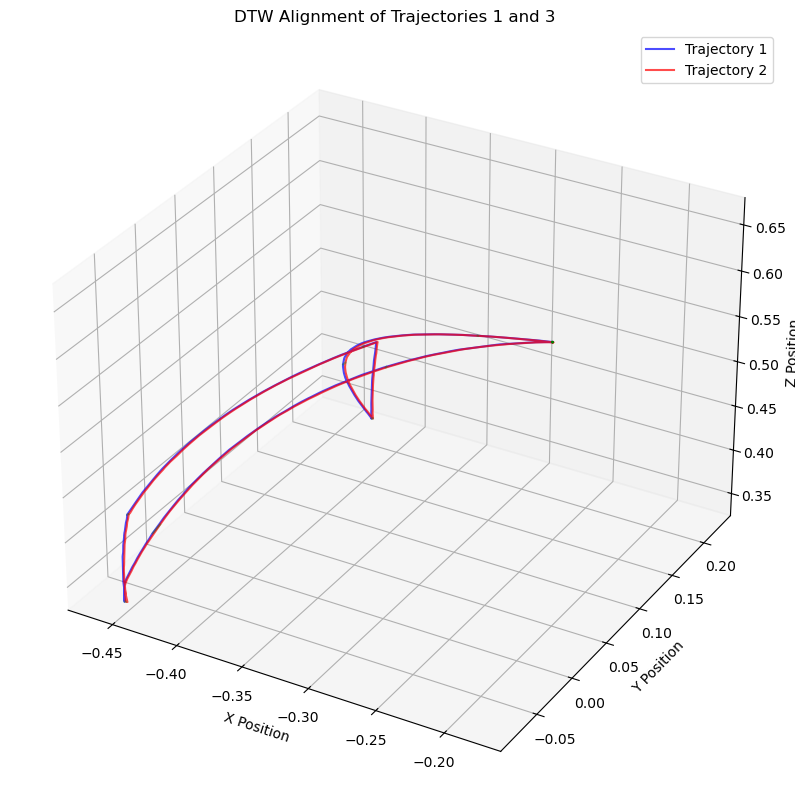

In [3]:
file_paths = ['Kinesthetic_teaching_take_1.csv',
                'Kinesthetic_teaching_take_2.csv',
                'Kinesthetic_teaching_take_3.csv', 
                'Kinesthetic_teaching_take_4.csv', 
                'Kinesthetic_teaching_take_5.csv', 
             ]

traj1, traj2, distance, path, alignment_plot = analyze_trajectory_similarity(file_paths)
plt.show()

Our usage of FastDTW uses Euclidean distance formula in the calculation of the DTW distance metric to calcuate the overall DTW cost map, which is used to determine the trajectory similarity. After testing every pair combination of the trajectories, the pair with the shortest DTW distance is the most similar. In this case, trajectories 1 and 3 were determined to be most similar, so therefore their plot is above.

### Part 2 (Identify a method for aligning multiple demonstrated trajectories)
Identify a method for aligning multiple demonstrated trajectories or develop your own method for aligning demonstrated trajectories. Explain the method you used/developed in a mathematical way and provide screenshots of the code and the results.

The alternative method we selected for aligning multiple trajectories is Probabilistic Movement Primitives (ProMPs -- https://arxiv.org/pdf/1808.10648). ProMPs represent trajectories as probability distributions over time, allowing you to:

1. Capture the mean trajectory and variability across demonstrations
2. Generate new trajectories that maintain task-relevant features
3. Time-align demonstrations through phase estimation
4. Handle multiple degrees of freedom simultaneously

When Compared to DTW, we can extract the following observations:
1. Probabilistic Framework:
- Instead of just aligning trajectories, ProMPs learn a probability distribution over trajectories
- Captures both average behavior and variability
- Can generate new trajectories that are similar to demonstrations

2. Phase-Based Alignment:
- Uses a normalized phase variable (0 to 1) to align trajectories
- More intuitive for robotic movements than DTW's warping path

3. Feature Extraction:
- Represents trajectories using basis functions
- Reduces dimensionality while maintaining important features
- Makes it easier to compare and analyze trajectories

From a mathematical perspective, ProMP can be explained in the following way:

1. **Foundation: Movement Representation**
The fundamental idea is to represent a trajectory τ(t) as a weighted sum of basis functions:

$τ(t) = ψ(t)ᵀw + ε$

Where:
- τ(t) is the trajectory at time t (position, velocity, etc.)
- ψ(t) is a vector of basis functions [ψ₁(t), ψ₂(t), ..., ψₙ(t)]
- w is the weight vector
- ε is zero-mean Gaussian noise: ε ~ N(0, σ²)

2. **Basis Functions**
Most commonly, normalized Gaussian basis functions are used:
$ψᵢ(t) = exp(-h(t - cᵢ)²)$

Where:
- cᵢ are the centers of the basis functions (evenly spaced in time)
- h controls the width of the basis functions
- The functions are normalized so $Σᵢψᵢ(t) = 1$ for all t

3. **Probabilistic Framework**
Instead of learning fixed weights, ProMP learns a distribution over weights:
p(w) = N(μw, Σw)

Where:
- μw is the mean weight vector
- Σw is the covariance matrix of weights

4. **Learning from Demonstrations**
Given M demonstrations, each containing T timesteps:
- Each demonstration d gives us a set of observed positions: $τd = {τd(t₁), ..., τd(tₜ)}$
- For each demonstration, we can stack the basis functions into a matrix Ψ:
  $Ψ = [ψ(t₁), ψ(t₂), ..., ψ(tₜ)]ᵀ$

The weights for each demonstration can be computed using:
$w_d = (ΨᵀΨ + λI)⁻¹Ψᵀτ_d$

Where:
- λ is a regularization term
- I is the identity matrix

5. **Computing Distribution Parameters**
After getting weights for all demonstrations:
- $μw = (1/M)Σᵢwᵢ$
- $Σw = (1/M)Σᵢ(wᵢ - μw)(wᵢ - μw)ᵀ$

6. **Generating New Trajectories**
To generate a new trajectory:
1. Sample weights: $w ~ N(μw, Σw)$
2. Compute trajectory: $τ(t) = ψ(t)ᵀw$

7. **Conditioning**
You can condition the distribution to pass through specific points:
Given a desired position y* at time t*:

$μw|y* = μw + Σw ψ(t*)(ψ(t*)ᵀΣwψ(t*) + σy²)⁻¹(y* - ψ(t*)ᵀμw)
Σw|y* = Σw - Σw ψ(t*)(ψ(t*)ᵀΣwψ(t*) + σy²)⁻¹ψ(t*)ᵀΣw$

8. **Key Properties**
- Time-Invariance: The basis functions handle temporal variations
- Correlation: Σw captures correlations between different parts of the movement
- Generalization: Can generate new trajectories maintaining demonstrated variability
- Conditioning: Can adapt to new situations through probabilistic conditioning

This mathematical framework allows ProMPs to:
1. Capture the essential features of demonstrated movements
2. Model the variability in demonstrations
3. Generate new trajectories that maintain task-relevant constraints
4. Adapt to new situations through conditioning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import pandas as pd

class ProMP:
    def __init__(self, n_basis=15, n_dof=3):
        """
        Initialize ProMP with number of basis functions and degrees of freedom
        
        Parameters:
        n_basis: number of basis functions
        n_dof: number of degrees of freedom (3 for position x,y,z)
        """
        self.n_basis = n_basis
        self.n_dof = n_dof
        self.weights = None
        self.weights_cov = None
        
    def generate_basis_functions(self, z):
        """
        Generate Gaussian basis functions
        
        Parameters:
        z: normalized time points (0 to 1)
        """
        # Centers of basis functions
        c = np.linspace(0, 1, self.n_basis)
        # Width of basis functions
        h = 1.0/(self.n_basis-1)
        
        # Generate basis functions
        phi = np.zeros((len(z), self.n_basis))
        for i in range(self.n_basis):
            phi[:, i] = np.exp(-0.5 * ((z - c[i])/h)**2)
        
        # Normalize basis functions
        phi = phi / phi.sum(axis=1)[:, None]
        return phi
    
    def align_trajectories(self, trajectories):
        """
        Time-align trajectories by resampling to the same number of points
        
        Parameters:
        trajectories: list of DataFrames containing trajectory data
        """
        # Find the median length
        median_length = int(np.median([len(traj) for traj in trajectories]))
        aligned_trajs = []
        
        for traj in trajectories:
            # Create interpolation functions for each dimension
            old_timestamps = np.linspace(0, 1, len(traj))
            new_timestamps = np.linspace(0, 1, median_length)
            
            aligned_data = {}
            for col in ['EE Position x', 'EE Position y', 'EE Position z']:
                f = interp1d(old_timestamps, traj[col], kind='cubic')
                aligned_data[col] = f(new_timestamps)
            
            aligned_trajs.append(pd.DataFrame(aligned_data))
        
        return aligned_trajs
    
    def fit(self, trajectories):
        """
        Fit ProMP to aligned trajectories
        
        Parameters:
        trajectories: list of aligned DataFrames
        """
        # Align trajectories
        aligned_trajs = self.align_trajectories(trajectories)
        n_points = len(aligned_trajs[0])
        
        # Generate basis functions
        z = np.linspace(0, 1, n_points)
        phi = self.generate_basis_functions(z)
        
        # Extract positions
        positions = np.array([[traj['EE Position x'].values,
                             traj['EE Position y'].values,
                             traj['EE Position z'].values] 
                            for traj in aligned_trajs])
        
        # Compute weights for each demonstration
        weights = []
        for demo in positions:
            # Solve least squares problem for each DOF
            w = np.zeros((self.n_dof, self.n_basis))
            for d in range(self.n_dof):
                w[d] = np.linalg.lstsq(phi, demo[d], rcond=None)[0]
            weights.append(w.flatten())
        
        weights = np.array(weights)
        
        # Compute mean and covariance of weights
        self.weights = np.mean(weights, axis=0)
        self.weights_cov = np.cov(weights.T)
        
        return self
    
    def generate_trajectory(self, n_points=100):
        """
        Generate a new trajectory from the learned distribution
        """
        z = np.linspace(0, 1, n_points)
        phi = self.generate_basis_functions(z)
        
        # Sample weights from distribution
        weights = np.random.multivariate_normal(self.weights, self.weights_cov)
        weights = weights.reshape(self.n_dof, -1)
        
        # Generate trajectory
        trajectory = np.zeros((self.n_dof, n_points))
        for d in range(self.n_dof):
            trajectory[d] = phi @ weights[d]
            
        return trajectory
    
    def plot_distribution(self, trajectories, n_samples=10):
        """
        Plot original trajectories and distribution
        """
        fig = plt.figure(figsize=(15, 5))
        titles = ['X Position', 'Y Position', 'Z Position']
        
        # Align trajectories for plotting
        aligned_trajs = self.align_trajectories(trajectories)
        n_points = len(aligned_trajs[0])
        t = np.linspace(0, 1, n_points)
        
        for d in range(self.n_dof):
            ax = fig.add_subplot(1, 3, d+1)
            
            # Plot original trajectories
            for traj in aligned_trajs:
                pos = traj[f'EE Position {"xyz"[d]}'].values
                ax.plot(t, pos, 'k-', alpha=0.2)
            
            # Generate and plot samples from distribution
            for _ in range(n_samples):
                traj = self.generate_trajectory(n_points)
                ax.plot(t, traj[d], 'r-', alpha=0.1)
            
            ax.set_title(titles[d])
            ax.set_xlabel('Phase')
            ax.set_ylabel('Position')
        
        plt.tight_layout()
        return fig

def analyze_trajectories_promp(file_paths, n_basis=15):
    """
    Analyze trajectories using ProMP
    """
    # Load trajectories
    trajectories = [pd.read_csv(path) for path in file_paths]
    
    # Create and fit ProMP
    promp = ProMP(n_basis=n_basis)
    promp.fit(trajectories)
    
    # Plot results
    fig = promp.plot_distribution(trajectories)
    
    return promp, fig

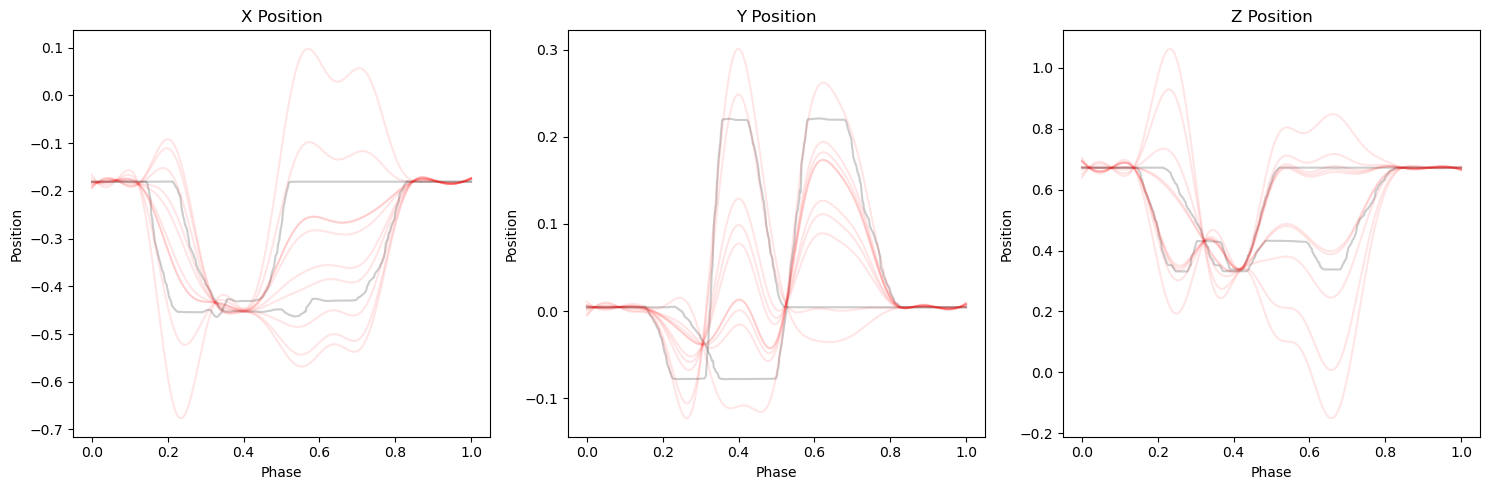

In [26]:
# file_paths = ['Kinesthetic_teaching_take_1.csv',
#                 'Kinesthetic_teaching_take_2.csv',
#                 'Kinesthetic_teaching_take_3.csv', 
#                 'Kinesthetic_teaching_take_4.csv', 
#                 'Kinesthetic_teaching_take_5.csv', 
#             ]

file_paths = ['Kinesthetic_teaching_take_1.csv',
                # 'Kinesthetic_teaching_take_2.csv',
                'Kinesthetic_teaching_take_3.csv', 
                # 'Kinesthetic_teaching_take_4.csv', 
                # 'Kinesthetic_teaching_take_5.csv', 
            ]

promp, fig = analyze_trajectories_promp(file_paths, n_basis=15)
plt.show()

In the above plots, the gray lines are the demonstrated trajectories and the red lines are the samples from the learned ProMP distributions. We can clearly see that this is a pick and place activity based on the xyz trajectories, but it is also clear that certain trajectories are easier for the algorithm to learn than others. Many of the red lines (learned trajectories) follow the correct position, but larger disturbances (like those in trajectory 5) can prevent it from learning as effectively. We can see the effect of these disturbances by the large deviations in the red lines for certain sampled trajectories. Below is another implementation with some more flexibility to tune the training parameters for a better end result.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import pandas as pd

class EnhancedProMP:
    def __init__(self, n_basis=15, basis_width_factor=1.0, regularization=1e-12, basis_type='gaussian'):
        """
        Initialize ProMP with tunable parameters
        
        Parameters:
        n_basis: number of basis functions
        basis_width_factor: controls width of basis functions (higher = wider)
        regularization: regularization term for weight fitting
        basis_type: type of basis functions ('gaussian' or 'vonmises')
        """
        self.n_basis = n_basis
        self.basis_width_factor = basis_width_factor
        self.regularization = regularization
        self.basis_type = basis_type
        self.n_dof = 3
        self.weights = None
        self.weights_cov = None
        
    def generate_basis_functions(self, z):
        """
        Generate basis functions with specified type
        """
        c = np.linspace(0, 1, self.n_basis)
        h = self.basis_width_factor/(self.n_basis-1)
        
        phi = np.zeros((len(z), self.n_basis))
        
        if self.basis_type == 'gaussian':
            for i in range(self.n_basis):
                phi[:, i] = np.exp(-0.5 * ((z - c[i])/h)**2)
        elif self.basis_type == 'vonmises':
            # von Mises basis functions (better for periodic movements)
            kappa = 1/(h**2)
            for i in range(self.n_basis):
                phi[:, i] = np.exp(kappa * (np.cos(2*np.pi*(z - c[i])) - 1))
                
        # Normalize basis functions
        sum_phi = phi.sum(axis=1)
        phi = phi / sum_phi[:, None]
        return phi
    
    def compute_basis_function_coverage(self, z):
        """
        Compute and visualize basis function coverage
        """
        phi = self.generate_basis_functions(z)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Plot individual basis functions
        for i in range(self.n_basis):
            ax1.plot(z, phi[:, i])
        ax1.set_title('Individual Basis Functions')
        ax1.set_xlabel('Phase')
        ax1.set_ylabel('Activation')
        
        # Plot sum of basis functions
        ax2.plot(z, phi.sum(axis=1))
        ax2.set_title('Sum of Basis Functions (should be close to 1)')
        ax2.set_xlabel('Phase')
        ax2.set_ylabel('Sum')
        ax2.set_ylim([0.9, 1.1])
        
        plt.tight_layout()
        return fig
    
    def align_trajectories(self, trajectories, n_points=100):
        """
        Time-align trajectories with optional length specification
        """
        aligned_trajs = []
        
        for traj in trajectories:
            old_timestamps = np.linspace(0, 1, len(traj))
            new_timestamps = np.linspace(0, 1, n_points)
            
            aligned_data = {}
            for col in ['EE Position x', 'EE Position y', 'EE Position z']:
                f = interp1d(old_timestamps, traj[col], kind='cubic')
                aligned_data[col] = f(new_timestamps)
            
            aligned_trajs.append(pd.DataFrame(aligned_data))
        
        return aligned_trajs
    
    def fit(self, trajectories, n_points=100):
        """
        Fit ProMP with regularization
        """
        aligned_trajs = self.align_trajectories(trajectories, n_points)
        
        # Generate basis functions
        z = np.linspace(0, 1, n_points)
        phi = self.generate_basis_functions(z)
        
        # Extract positions
        positions = np.array([[traj['EE Position x'].values,
                             traj['EE Position y'].values,
                             traj['EE Position z'].values] 
                            for traj in aligned_trajs])
        
        # Compute weights with regularization
        weights = []
        for demo in positions:
            w = np.zeros((self.n_dof, self.n_basis))
            for d in range(self.n_dof):
                # Add regularization term
                A = phi.T @ phi + self.regularization * np.eye(self.n_basis)
                b = phi.T @ demo[d]
                w[d] = np.linalg.solve(A, b)
            weights.append(w.flatten())
        
        weights = np.array(weights)
        
        # Compute mean and covariance of weights
        self.weights = np.mean(weights, axis=0)
        self.weights_cov = np.cov(weights.T)
        
        return self
    
    def compute_reconstruction_error(self, trajectories):
        """
        Compute reconstruction error for each trajectory
        """
        aligned_trajs = self.align_trajectories(trajectories)
        n_points = len(aligned_trajs[0])
        z = np.linspace(0, 1, n_points)
        phi = self.generate_basis_functions(z)
        
        errors = []
        for traj in aligned_trajs:
            # Original trajectory
            orig = np.array([traj['EE Position x'].values,
                           traj['EE Position y'].values,
                           traj['EE Position z'].values])
            
            # Reconstructed trajectory
            weights = self.weights.reshape(self.n_dof, -1)
            recon = np.zeros((self.n_dof, n_points))
            for d in range(self.n_dof):
                recon[d] = phi @ weights[d]
            
            # Compute RMS error
            error = np.sqrt(np.mean((orig - recon)**2))
            errors.append(error)
            
        return np.mean(errors), np.std(errors)
    
    def plot_training_diagnostics(self, trajectories):
        """
        Plot diagnostic information about the ProMP fitting
        """
        fig = plt.figure(figsize=(15, 10))
        
        # Plot basis function coverage
        ax1 = fig.add_subplot(221)
        z = np.linspace(0, 1, 100)
        phi = self.generate_basis_functions(z)
        ax1.plot(z, phi)
        ax1.set_title('Basis Functions')
        
        # Plot weight distribution
        ax2 = fig.add_subplot(222)
        ax2.hist(self.weights, bins=20)
        ax2.set_title('Weight Distribution')
        
        # Plot covariance matrix
        ax3 = fig.add_subplot(223)
        im = ax3.imshow(self.weights_cov)
        plt.colorbar(im, ax=ax3)
        ax3.set_title('Weight Covariance Matrix')
        
        # Plot reconstruction error distribution
        aligned_trajs = self.align_trajectories(trajectories)
        errors = []
        for traj in aligned_trajs:
            orig = np.array([traj['EE Position x'].values,
                           traj['EE Position y'].values,
                           traj['EE Position z'].values])
            z = np.linspace(0, 1, len(traj))
            phi = self.generate_basis_functions(z)
            weights = self.weights.reshape(self.n_dof, -1)
            recon = np.zeros((self.n_dof, len(traj)))
            for d in range(self.n_dof):
                recon[d] = phi @ weights[d]
            error = np.sqrt(np.mean((orig - recon)**2))
            errors.append(error)
            
        ax4 = fig.add_subplot(224)
        ax4.hist(errors, bins=10)
        ax4.set_title('Reconstruction Error Distribution')
        
        plt.tight_layout()
        return fig
    
    def generate_trajectory(self, n_points=100):
        """
        Generate a new trajectory from the learned distribution
        """
        z = np.linspace(0, 1, n_points)
        phi = self.generate_basis_functions(z)
        
        # Sample weights from distribution
        weights = np.random.multivariate_normal(self.weights, self.weights_cov)
        weights = weights.reshape(self.n_dof, -1)
        
        # Generate trajectory
        trajectory = np.zeros((self.n_dof, n_points))
        for d in range(self.n_dof):
            trajectory[d] = phi @ weights[d]
            
        return trajectory
    
    def plot_distribution(self, trajectories, n_samples=10):
        """
        Plot original trajectories and distribution
        """
        fig = plt.figure(figsize=(15, 5))
        titles = ['X Position', 'Y Position', 'Z Position']
        
        # Align trajectories for plotting
        aligned_trajs = self.align_trajectories(trajectories)
        n_points = len(aligned_trajs[0])
        t = np.linspace(0, 1, n_points)
        
        for d in range(self.n_dof):
            ax = fig.add_subplot(1, 3, d+1)
            
            # Plot original trajectories
            for traj in aligned_trajs:
                pos = traj[f'EE Position {"xyz"[d]}'].values
                ax.plot(t, pos, 'k-', alpha=0.2)
            
            # Generate and plot samples from distribution
            for _ in range(n_samples):
                traj = self.generate_trajectory(n_points)
                ax.plot(t, traj[d], 'r-', alpha=0.1)
            
            ax.set_title(titles[d])
            ax.set_xlabel('Phase')
            ax.set_ylabel('Position')
        
        plt.tight_layout()
        return fig

def tune_promp(trajectories, n_basis_range=[10, 15, 20, 25], 
               width_factors=[0.5, 1.0, 1.5, 2.0],
               regularization_values=[1e-12, 1e-8, 1e-4]):
    """
    Perform grid search over ProMP parameters
    """
    best_error = float('inf')
    best_params = None
    results = []
    
    for n_basis in n_basis_range:
        for width in width_factors:
            for reg in regularization_values:
                promp = EnhancedProMP(n_basis=n_basis, 
                                    basis_width_factor=width,
                                    regularization=reg)
                promp.fit(trajectories)
                mean_error, std_error = promp.compute_reconstruction_error(trajectories)
                
                results.append({
                    'n_basis': n_basis,
                    'width_factor': width,
                    'regularization': reg,
                    'mean_error': mean_error,
                    'std_error': std_error
                })
                
                if mean_error < best_error:
                    best_error = mean_error
                    best_params = (n_basis, width, reg)
    
    return pd.DataFrame(results), best_params

# trajectories = [pd.read_csv(path) for path in file_paths]

# # Tune ProMP
# results_df, (best_n_basis, best_width, best_reg) = tune_promp(trajectories)
# print("\nBest parameters:")
# print(f"Number of basis functions: {best_n_basis}")
# print(f"Basis width factor: {best_width}")
# print(f"Regularization: {best_reg}")

# # Train ProMP with parameters identified above
# promp = EnhancedProMP(n_basis=best_n_basis,
#                         basis_width_factor=best_width,
#                         regularization=best_reg)
# promp.fit(trajectories)
    
# # Plot diagnostics
# diagnostics_plot = promp.plot_training_diagnostics(trajectories)

# # Plot sampled trajectories
# distribution_plot = promp.plot_distribution(trajectories, n_samples=10)

# plt.show()


Best parameters:
Number of basis functions: 25
Basis width factor: 1.5
Regularization: 1e-12


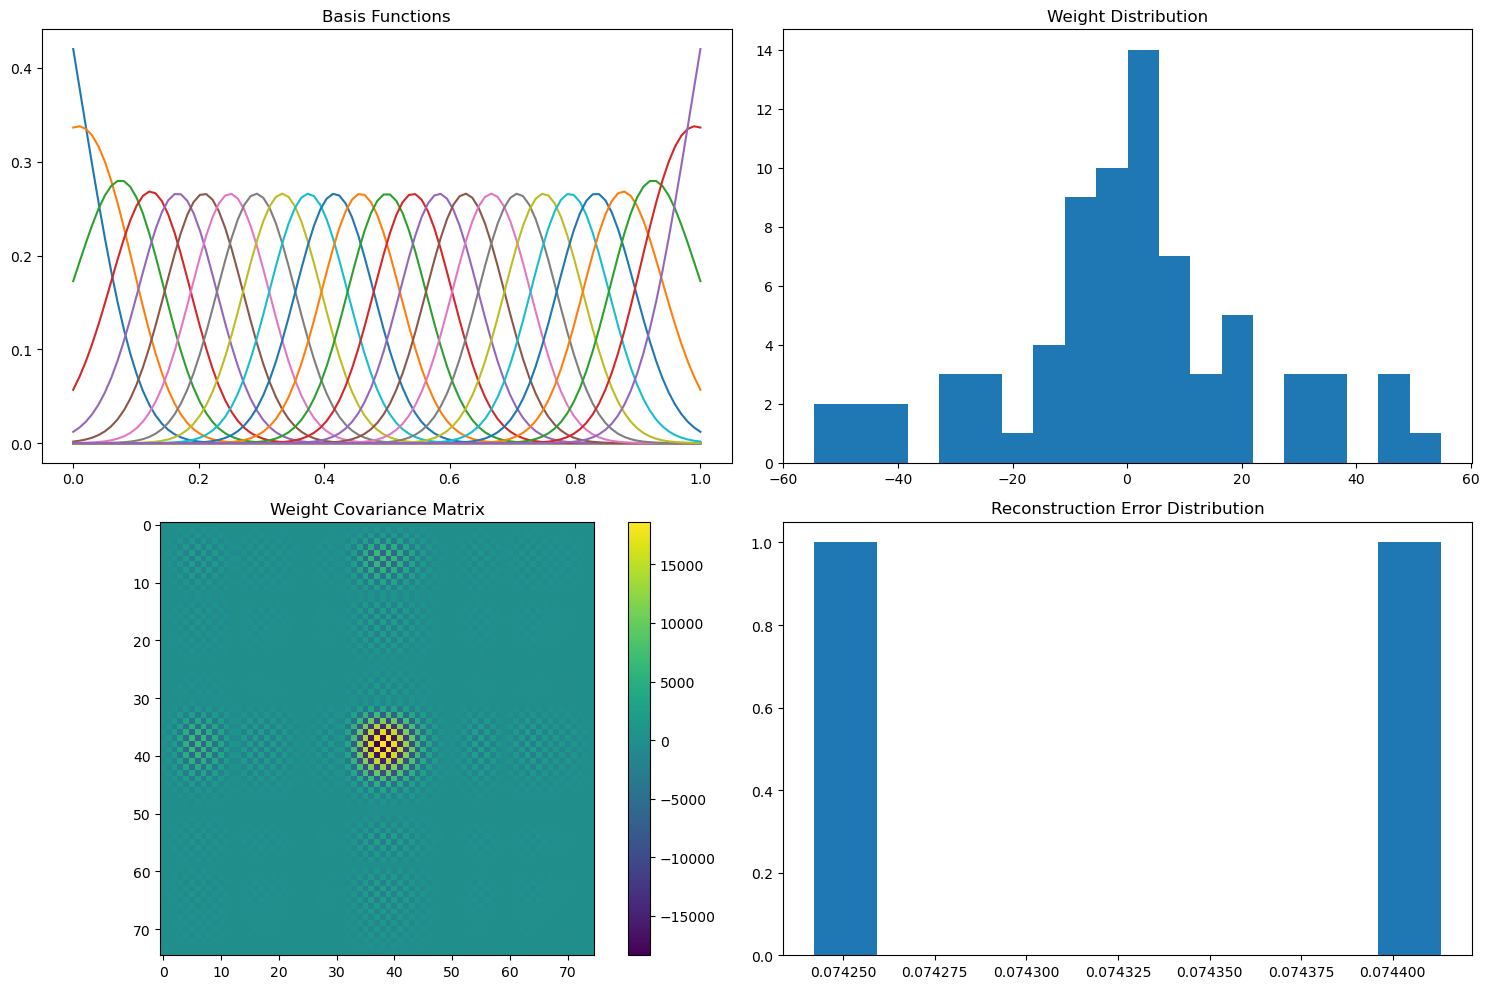

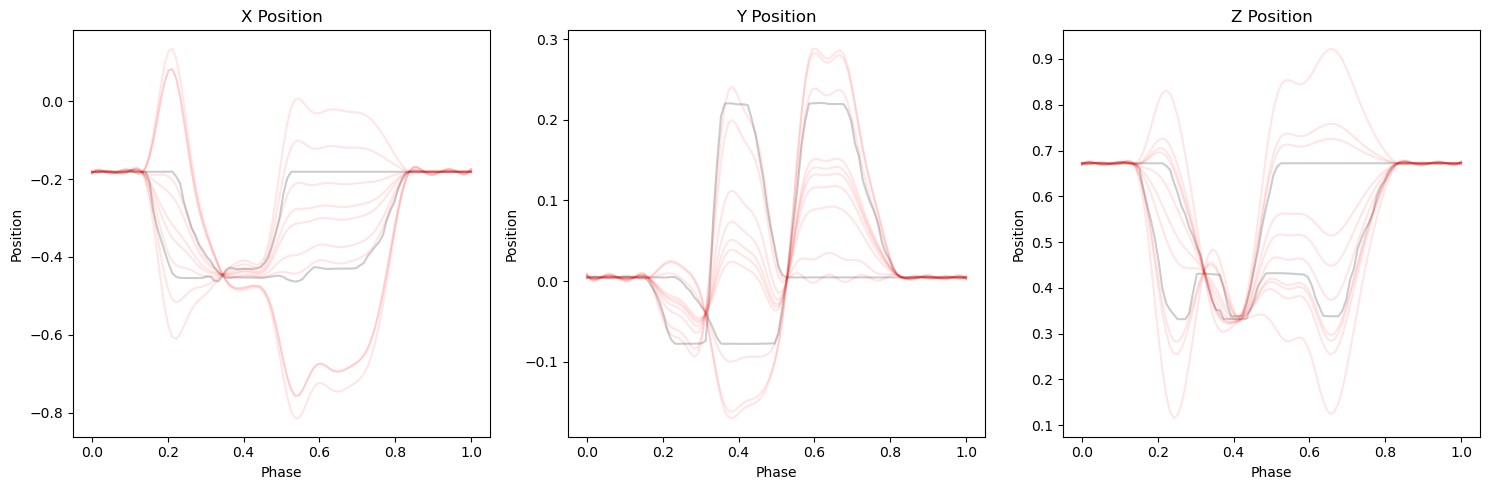

In [32]:
trajectories = [pd.read_csv(path) for path in file_paths]

# Tune ProMP
results_df, (best_n_basis, best_width, best_reg) = tune_promp(trajectories)
print("\nBest parameters:")
print(f"Number of basis functions: {best_n_basis}")
print(f"Basis width factor: {best_width}")
print(f"Regularization: {best_reg}")

# Train ProMP with parameters identified above
promp = EnhancedProMP(n_basis=best_n_basis,
                        basis_width_factor=best_width,
                        regularization=best_reg)
promp.fit(trajectories)
    
# Plot diagnostics
diagnostics_plot = promp.plot_training_diagnostics(trajectories)

# Plot sampled trajectories
distribution_plot = promp.plot_distribution(trajectories, n_samples=10)

plt.show()